<a href="https://colab.research.google.com/github/shreyasat27/pennylane-27524/blob/main/He_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install openfermionpyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=e5841aca4778ee788e568d78a30383491c74d7cb97e42e342a861e003997699e
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 29.7 MB/s eta 0:00:00


Number of qubits =  4
The Hamiltonian is  -0.042072551947439224 * I(0) + 0.1777135822909176 * Z(0) + -0.2427450126094144 * Z(2) + 0.12293330449299361 * (Z(0) @ Z(2)) + 0.1777135822909176 * Z(1) + 0.17059759276836803 * (Z(0) @ Z(1)) + 0.044750084063019925 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.044750084063019925 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.044750084063019925 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.044750084063019925 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.2427450126094144 * Z(3) + 0.16768338855601356 * (Z(0) @ Z(3)) + 0.12293330449299361 * (Z(1) @ Z(3)) + 0.16768338855601356 * (Z(1) @ Z(2)) + 0.1762766139418181 * (Z(2) @ Z(3))
[1 1 0 0]


/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


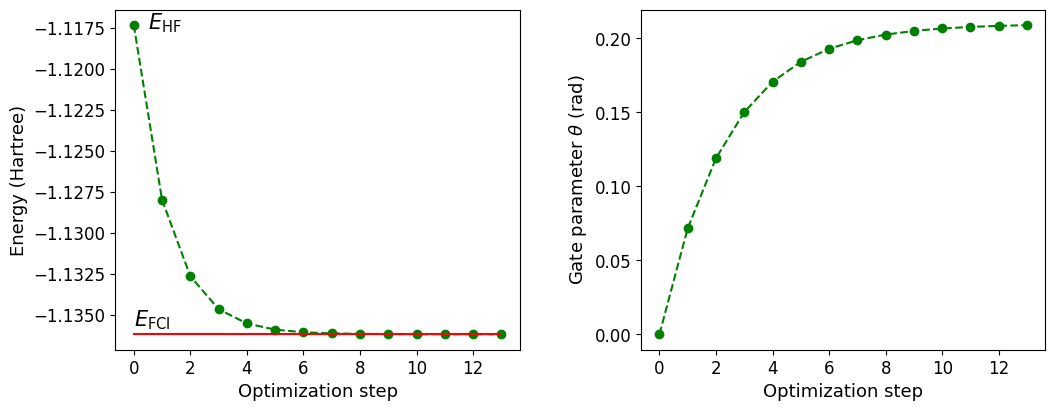

In [17]:
from jax import numpy as np
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

symbols = ["H","H"]
coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])

molecule = qml.qchem.Molecule(symbols, coordinates)
H, qubits = qml.qchem.molecular_hamiltonian(molecule)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

dev = qml.device("lightning.qubit", wires=qubits)

electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

def cost_fn(param):
    return circuit(param, wires=range(qubits))

import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")


import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

In [20]:
from jax import numpy as np
import jax
import pennylane as qml

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [22]:
symbols = ["He", "He"]
coordinates = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 1.68]])

In [47]:
dataset = qml.data.load('qchem', molname="He2")[0]
He2, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", He2)

Number of qubits =  8
The Hamiltonian is  -1.6743100655776795 * I(0) + 0.34164129511099833 * Z(0) + 0.015234073387742634 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + 0.015234073387742634 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + 0.3416412951109985 * Z(1) + 0.015234073387742651 * (Y(1) @ Z(2) @ Z(3) @ Z(4) @ Y(5)) + 0.015234073387742651 * (X(1) @ Z(2) @ Z(3) @ Z(4) @ X(5)) + 0.3416408311620214 * Z(2) + -0.015234388911926917 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.015234388911926917 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.34164083116202126 * Z(3) + -0.015234388911926931 * (Y(3) @ Z(4) @ Z(5) @ Z(6) @ Y(7)) + -0.015234388911926931 * (X(3) @ Z(4) @ Z(5) @ Z(6) @ X(7)) + -0.5193693204313438 * Z(4) + -0.5193693204313439 * Z(5) + -0.51937337612909 * Z(6) + -0.51937337612909 * Z(7) + 0.1410838720389413 * (Z(0) @ Z(1)) + 0.03956129782205245 * (Y(0) @ Z(2) @ Z(3) @ Y(4)) + 0.03956129782205245 * (X(0) @ Z(2) @ Z(3) @ X(4)) + 0.11564281616295638 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.11564281616295638 * (Y(

In [51]:
# Adjust the device and electron count accordingly
dev = qml.device("lightning.qubit", wires=qubits)
electrons = 4  # Two He atoms have 4 electrons in total
hf = qml.qchem.hf_state(electrons, qubits)
print("Hartree-Fock state: ", hf)


Hartree-Fock state:  [1 1 1 1 0 0 0 0]


In [52]:
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2,3 ])  # Adjust the wires for He2
    return qml.expval(He2)

In [53]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

In [57]:
import optax

max_iterations = 1000
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [58]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -5.71032085 Ha

Final value of the ground-state energy = -5.71032085 Ha

Optimal value of the circuit parameter = 0.0000


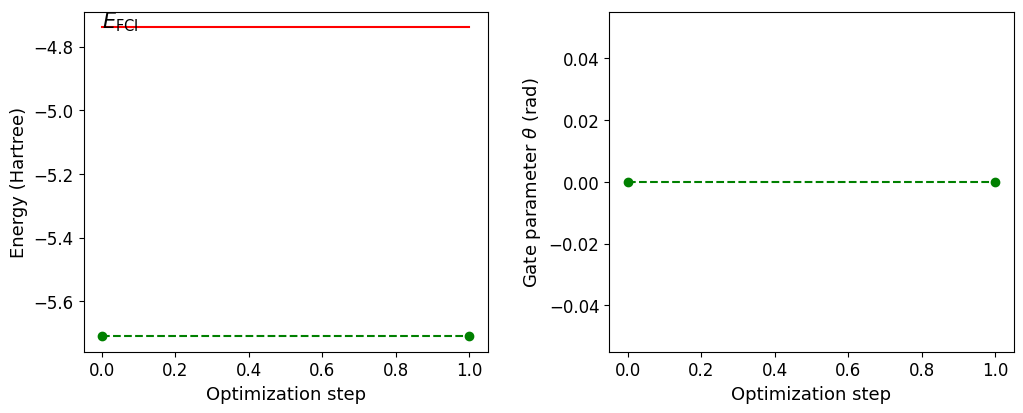

In [56]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -4.739  # Adjusted FCI energy for He2

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0, -4.739, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()
